In [2]:
#CONEXIÓN A SNOWFLAKE Y OBTENCIÓN DE DATOS

import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conectar a Snowflake
conn = snowflake.connector.connect(
    account='ABPWBUP-LSB46287',
    user='SERVICE',
    password='pofnIk-6kikhe-bokbyj',
    warehouse='COMPUTE_WH',
    database='INSTACART_DB',
    schema='CLEAN',
    role='ACCOUNTADMIN'
)

# Función para obtener datos de Snowflake
def obtener_datos(query):
    cur = conn.cursor()
    cur.execute(query)
    data = cur.fetchall()
    columns = [desc[0] for desc in cur.description]
    cur.close()
    return pd.DataFrame(data, columns=columns)

# Obtener lista de tablas en el esquema CLEAN
tablas_query = "SHOW TABLES IN SCHEMA CLEAN"
tablas_df = obtener_datos(tablas_query)
tablas = tablas_df['name'].tolist()


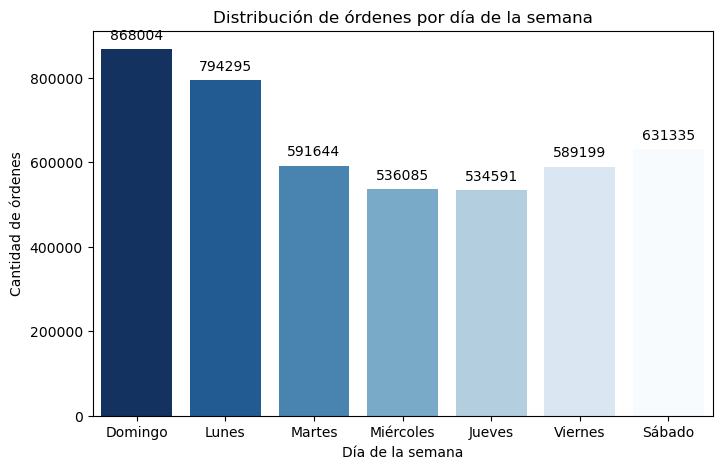

In [22]:
# Comportamiento de compra según día de la semana
def compras_por_dia_semana():
    query = 'SELECT "order_dow", COUNT(*) AS "TOTAL_ORDENES" FROM FACT_ORDERS_PRODUCTS GROUP BY "order_dow" ORDER BY "order_dow";'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()  # Asegurar que todas las columnas estén en mayúsculas
    dias_semana = ['Domingo', 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df['ORDER_DOW'], y=df['TOTAL_ORDENES'], hue=df['ORDER_DOW'], palette="Blues_r", legend=False)
    plt.xlabel("Día de la semana")
    plt.ylabel("Cantidad de órdenes")
    plt.title("Distribución de órdenes por día de la semana")
    plt.xticks(ticks=range(7), labels=dias_semana)  # Reemplazar números con nombres de días
    
    # Agregar etiquetas sobre cada barra con el número exacto de órdenes
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.show()

compras_por_dia_semana()

Se observa que los días de mayor volumen de pedidos son el domingo y el lunes, mientras que los días con menor actividad son miércoles y jueves, lo que puede reflejar que los consumidores organizan sus compras alrededor de su tiempo libre y el inicio de la semana. En particular, para los días con picos más altos de órdenes, se recomienda reforzar el abastecimiento de inventario en días previos (viernes y sábado) para asegurar disponibilidad de productos y evitar quiebres de stock. Y, a su vez, los días con menor demanda (miércoles y jueves) pueden ser utilizados para realizar reposiciones sin afectar la operación.

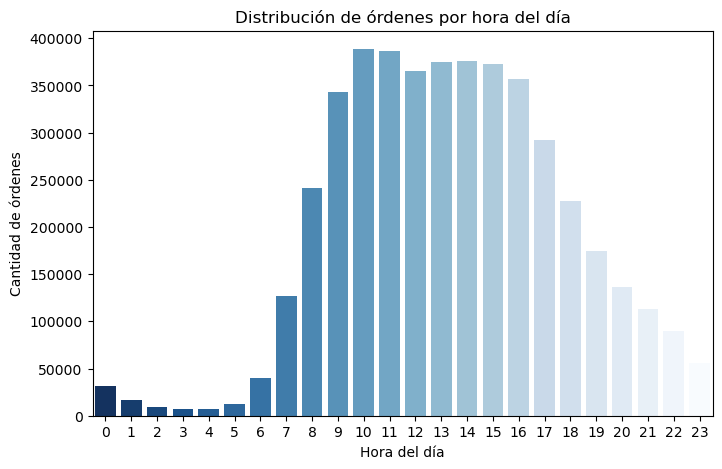

In [24]:
def compras_por_hora():
    query = 'SELECT "order_hour_of_day", COUNT(*) AS "TOTAL_ORDENES" FROM FACT_ORDERS_PRODUCTS GROUP BY "order_hour_of_day" ORDER BY "order_hour_of_day";'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    plt.figure(figsize=(8,5))
    sns.barplot(x=df['ORDER_HOUR_OF_DAY'], y=df['TOTAL_ORDENES'], hue=df['ORDER_HOUR_OF_DAY'], palette="Blues_r", legend=False)
    plt.xlabel("Hora del día")
    plt.ylabel("Cantidad de órdenes")
    plt.title("Distribución de órdenes por hora del día")
    plt.show()

compras_por_hora()

El gráfico destaca un pico de actividad entre las 9:00 y las 15:00 horas, llegando a su máximo entre las 11:00-13:00, y experimentando una caída progresiva después de las 16:00 y niveles bajos de actividad durante la madrugada. El mayor volumen de órdenes se concentra en las horas de la mañana y el mediodía, lo que sugiere que muchas personas realizan pedidos temprano en la jornada, posiblemente antes o durante el inicio de su rutina laboral. Por lo tanto, se sugier que la empresa aproveche los horarios de mayor tráfico y desarrollar incentivos para equilibrar la actividad en otros momentos del día puede aumentar la eficiencia y rentabilidad de la operación.

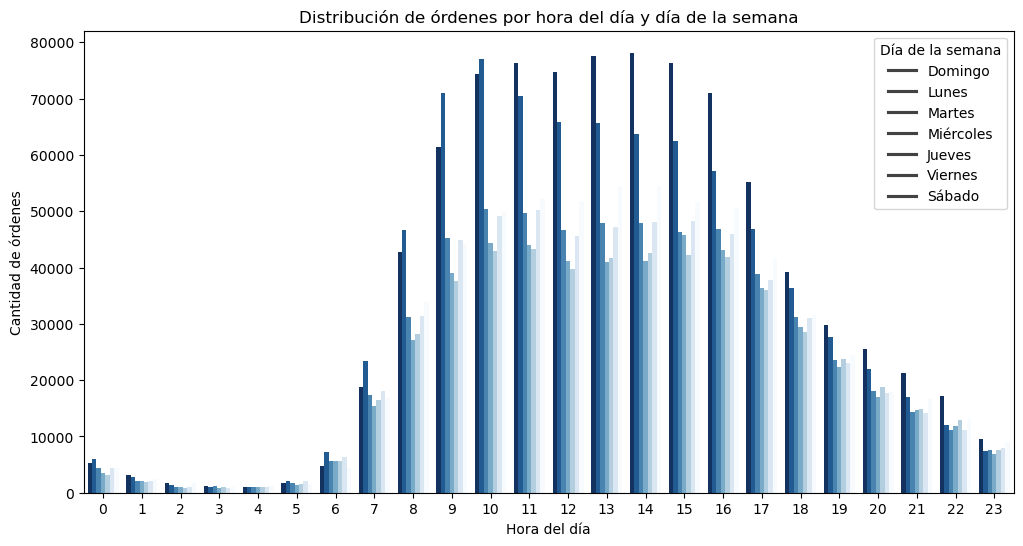

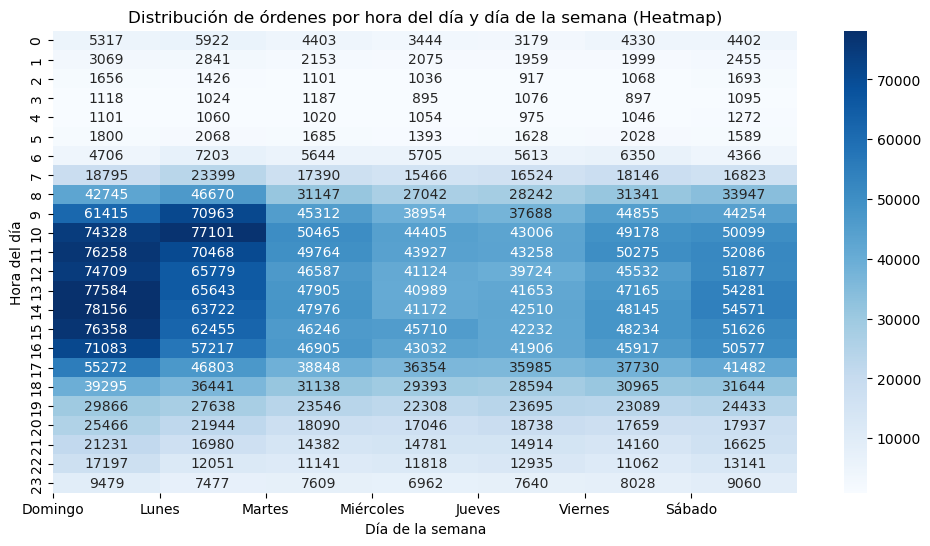

In [35]:
def compras_por_dia_y_hora():
    query = 'SELECT "order_dow", "order_hour_of_day", COUNT(*) AS "TOTAL_ORDENES" FROM FACT_ORDERS_PRODUCTS GROUP BY "order_dow", "order_hour_of_day" ORDER BY "order_dow", "order_hour_of_day";'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    dias_semana = ['Domingo', 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado']
    
    # Gráfico de barras
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=df['ORDER_HOUR_OF_DAY'], y=df['TOTAL_ORDENES'], hue=df['ORDER_DOW'], palette="Blues_r")
    plt.xlabel("Hora del día")
    plt.ylabel("Cantidad de órdenes")
    plt.title("Distribución de órdenes por hora del día y día de la semana")
    plt.legend(title="Día de la semana", labels=['Domingo', 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado'])
    plt.show()
    
    # Heatmap
    pivot = df.pivot(index='ORDER_HOUR_OF_DAY', columns='ORDER_DOW', values='TOTAL_ORDENES')
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap="Blues", annot=True, fmt=".0f")
    plt.title("Distribución de órdenes por hora del día y día de la semana (Heatmap)")
    plt.xlabel("Día de la semana")
    plt.ylabel("Hora del día")
    plt.xticks(ticks=range(7), labels=dias_semana)  # Reemplazar números con nombres de días
    plt.show()
compras_por_dia_y_hora()

Se evidencia que todos los días siguen un patrón similar: la cantidad de órdenes comienza a aumentar después de las 6:00, alcanzando su punto máximo entre las 9:00 y 14:00, lo que indica que la mayoría de los pedidos se realizan en el primer tramo del día. Además, como se observó en gráficos previos, el domingo y el lunes concentran el mayor número de órdenes, y en general, la actividad en estos días es notablemente más alta en comparación con otros días de la semana; lo que refleja los hábitos de compra de los clientes. Además, se observa una disminución gradual en la tarde y noche, pues a partir de las 16:00, la actividad empieza a reducirse de manera constante, y después de las 20:00, las órdenes son significativamente menores. Este patrón permite a la empresa optimizar su operación y diseñar estrategias de marketing y ventas enfocadas en los horarios clave.

El número promedio de órdenes por cliente es: 30.38
El número máximo de órdenes es: 580.00
El número mínimo de órdenes es: 1.00


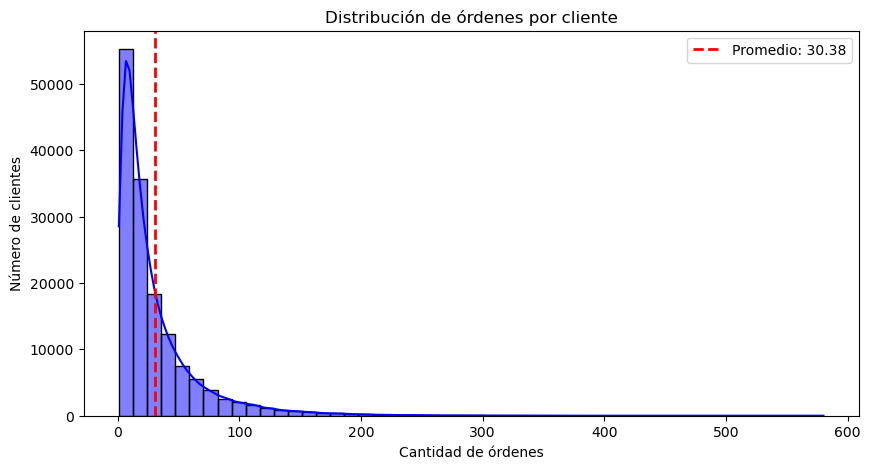

In [39]:
def distribucion_ordenes_por_cliente():
    query = 'SELECT "user_id", COUNT(*) AS "TOTAL_ORDENES" FROM FACT_ORDERS_PRODUCTS GROUP BY "user_id" ORDER BY "TOTAL_ORDENES" DESC;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Calcular el promedio de órdenes por cliente
    promedio_ordenes = df['TOTAL_ORDENES'].mean()
    print(f"El número promedio de órdenes por cliente es: {promedio_ordenes:.2f}")
    max_ordenes = df['TOTAL_ORDENES'].max()
    print(f"El número máximo de órdenes es: {max_ordenes:.2f}")
    min_ordenes = df['TOTAL_ORDENES'].min()
    print(f"El número mínimo de órdenes es: {min_ordenes:.2f}")
    
    # Histograma de la distribución de órdenes por cliente
    plt.figure(figsize=(10,5))
    sns.histplot(df['TOTAL_ORDENES'], bins=50, kde=True, color="blue")
    plt.xlabel("Cantidad de órdenes")
    plt.ylabel("Número de clientes")
    plt.title("Distribución de órdenes por cliente")
    plt.axvline(promedio_ordenes, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {promedio_ordenes:.2f}')
    plt.legend()
    plt.show()

distribucion_ordenes_por_cliente()

La mayoría de los clientes realizan pocas órdenes, pues se observa un alto número de clientes con menos de 30 órdenes. Esto sugiere que la base de clientes está compuesta en su mayoría por compradores ocasionales o nuevos clientes. Sin embargo, sí existen algunos clientes con una gran cantidad de órdenes, pero son una minoría. Estos clientes representan compradores leales o empresas con pedidos frecuentes. Además, cabe reclacar que el promedio de órdenes es de 30.38. Este análisis revela una clara oportunidad de negocio: el negocio tiene una base amplia de clientes, pero la mayoría solo compra pocas veces. La clave para aumentar la rentabilidad es desarrollar estrategias de fidelización que incentiven la recompra y fortalezcan la lealtad del cliente. También se puede segmentar la base de clientes para ofrecer estrategias diferenciadas entre compradores ocasionales y recurrentes.

/var/folders/ln/mfkv6_4j2zq5t91clsbxgnx00000gn/T/ipykernel_6860/3010573345.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['PRODUCT_NAME'], y=df['FRECUENCIA'], palette="Blues_r", legend=False)


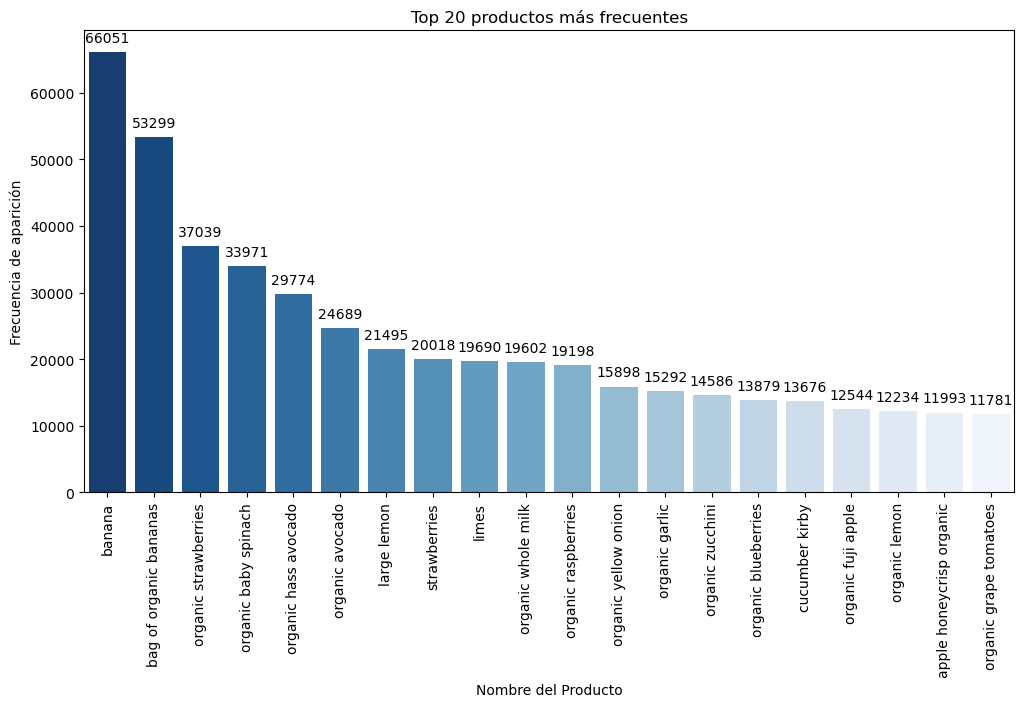

In [46]:
def top_20_productos_frecuentes():
    query = 'SELECT p."product_name", COUNT(f."product_id") AS "FRECUENCIA" FROM FACT_ORDERS_PRODUCTS f JOIN DIM_PRODUCTS p ON f."product_id" = p."product_id" GROUP BY p."product_name" ORDER BY "FRECUENCIA" DESC LIMIT 20;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Gráfico de barras de los 20 productos más frecuentes con nombres en el eje X
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=df['PRODUCT_NAME'], y=df['FRECUENCIA'], palette="Blues_r", legend=False)
    plt.xlabel("Nombre del Producto")
    plt.ylabel("Frecuencia de aparición")
    plt.title("Top 20 productos más frecuentes")
    plt.xticks(rotation=90)
    
    # Agregar etiquetas sobre cada barra con la frecuencia exacta
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.show()

top_20_productos_frecuentes()

La mayoría de los productos en el top 20 son orgánicos, lo que indica una tendencia de consumo hacia opciones saludables y ecológicas. En particular, se observa que las frutas lideran las compras, con la banana y la bolsa de bananas orgánicas siendo los productos más populares. Así pues, los datos reflejan que los clientes tienen una clara preferencia por productos frescos, naturales y orgánicos, especialmente frutas y vegetales. Esto representa una oportunidad para fortalecer la oferta de productos saludables, mejorar el inventario y lanzar estrategias promocionales que maximicen las ventas en estas categorías clave.

El número promedio de artículos por pedido es: 10.10


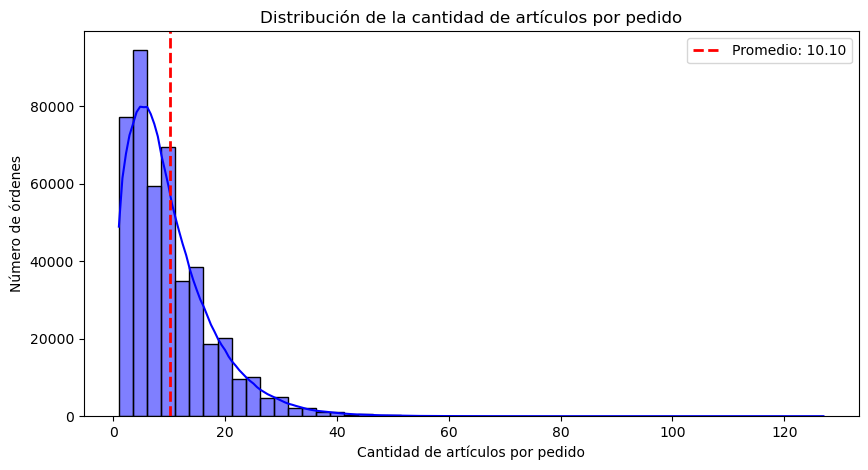

In [47]:
# Función para analizar la distribución de la cantidad de artículos por orden
def distribucion_articulos_por_pedido():
    query = 'SELECT "order_id", COUNT(*) AS "TOTAL_ARTICULOS" FROM FACT_ORDERS_PRODUCTS GROUP BY "order_id" ORDER BY "TOTAL_ARTICULOS" DESC;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Calcular el promedio de artículos por pedido
    promedio_articulos = df['TOTAL_ARTICULOS'].mean()
    print(f"El número promedio de artículos por pedido es: {promedio_articulos:.2f}")
    
    # Histograma de la distribución de artículos por pedido
    plt.figure(figsize=(10,5))
    sns.histplot(df['TOTAL_ARTICULOS'], bins=50, kde=True, color="blue")
    plt.xlabel("Cantidad de artículos por pedido")
    plt.ylabel("Número de órdenes")
    plt.title("Distribución de la cantidad de artículos por pedido")
    plt.axvline(promedio_articulos, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {promedio_articulos:.2f}')
    plt.legend()
    plt.show()

distribucion_articulos_por_pedido()

Se observa que la mayoría de los pedidos contienen una cantidad baja de artículos que se enceuntra en el rango de entre 5 y 15 (con un promedio de 10 artículos por pedido), lo que sugiere que los clientes suelen hacer compras específicas en lugar de pedidos grandes. Sin embargo, también se debe mencionar que algunos pedidos alcanzan más de 50 o incluso 100 artículos, lo que indica que existen clientes que realizan compras masivas o por volumen, posiblemente empresas o consumidores recurrentes que hacen pedidos grandes. Así pues, se afirma que hay una gran oportunidad para aumentar el tamaño promedio del pedido a través de promociones, incentivos de volumen y estrategias de cross-selling. Segmentar a los clientes según sus patrones de compra permitirá mejorar la eficiencia y rentabilidad del negocio.

/var/folders/ln/mfkv6_4j2zq5t91clsbxgnx00000gn/T/ipykernel_6860/56012909.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['PRODUCT_NAME'], y=df['REORDENADOS'], palette="Blues_r")


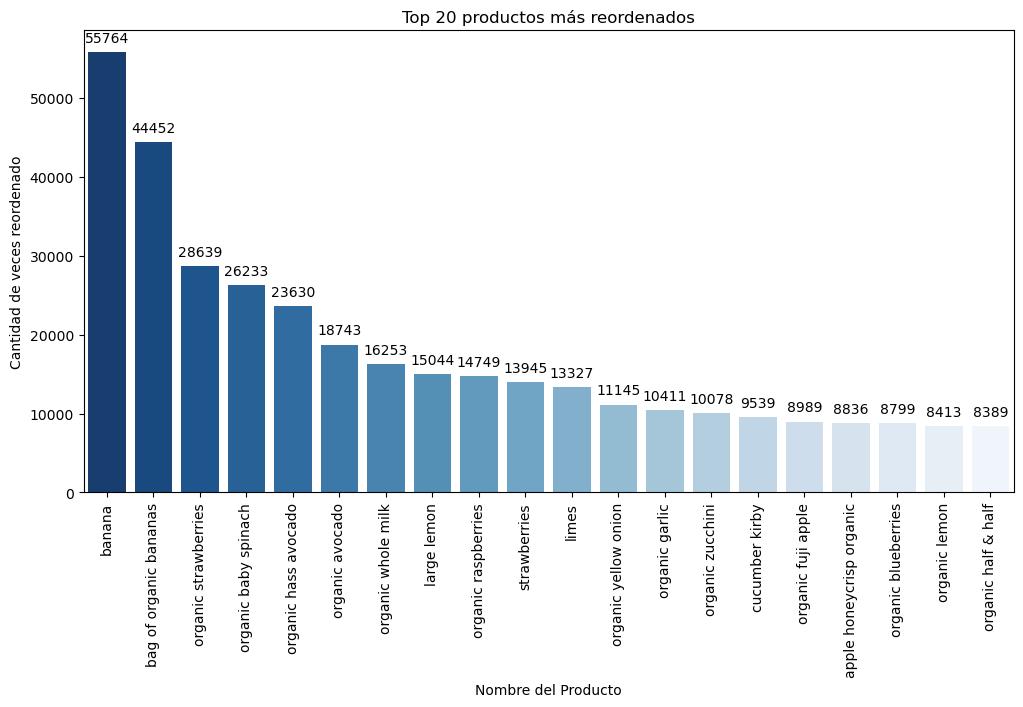

In [53]:
# Función para obtener el top 20 productos más reordenados
def top_20_productos_reordenados():
    query = 'SELECT p."product_name", COUNT(*) AS "REORDENADOS" FROM FACT_ORDERS_PRODUCTS f JOIN DIM_PRODUCTS p ON f."product_id" = p."product_id" WHERE f."reordered" = 1 GROUP BY p."product_name" ORDER BY "REORDENADOS" DESC LIMIT 20;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Gráfico de barras de los 20 productos más reordenados con nombres en el eje X
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=df['PRODUCT_NAME'], y=df['REORDENADOS'], palette="Blues_r")
    plt.xlabel("Nombre del Producto")
    plt.ylabel("Cantidad de veces reordenado")
    plt.title("Top 20 productos más reordenados")
    plt.xticks(rotation=90)
    
    # Agregar etiquetas sobre cada barra con la frecuencia exacta
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.show()

top_20_productos_reordenados()


Se observa que las bananas y los productos orgánicos dominan la lista de productos más reordenados, indicando un fuerte patrón de consumo recurrente que afirma la preferencia de los clientes por productos saludables y naturales; y sugiere una gran oportunidad para fortalecer estrategias de fidelización, suscripciones y optimización de stock.

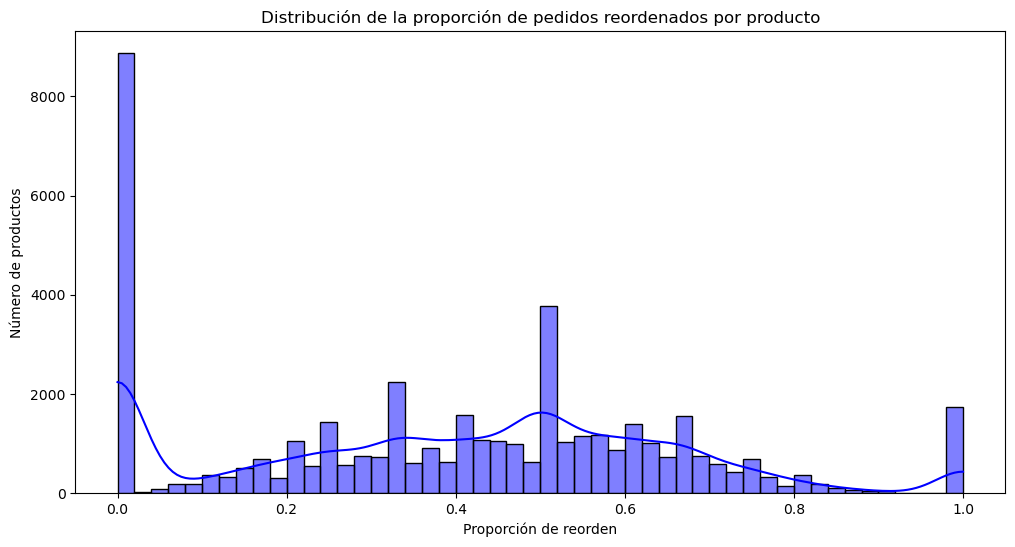

In [54]:
# Función para calcular la proporción de pedidos que se vuelven a pedir para cada producto
def proporcion_reorden_por_producto():
    query = 'SELECT p."product_name", SUM(f."reordered") / COUNT(f."product_id") AS "PROPORCION_REORDEN" FROM FACT_ORDERS_PRODUCTS f JOIN DIM_PRODUCTS p ON f."product_id" = p."product_id" GROUP BY p."product_name" ORDER BY "PROPORCION_REORDEN" DESC;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Histograma de la proporción de reorden por producto
    plt.figure(figsize=(12,6))
    sns.histplot(df['PROPORCION_REORDEN'], bins=50, kde=True, color="blue")
    plt.xlabel("Proporción de reorden")
    plt.ylabel("Número de productos")
    plt.title("Distribución de la proporción de pedidos reordenados por producto")
    plt.show()

proporcion_reorden_por_producto()


Se evidencia dos grupos claros de productos: aquellos con recompras muy frecuentes (bienes de consumo recurrentes) y aquellos que apenas se reordenan (bienes ocasionales). Para mejorar la rentabilidad del negocio, es clave fomentar la recompra de productos con baja frecuencia y maximizar el potencial de los productos con recompra alta mediante estrategias de fidelización, descuentos y suscripciones.

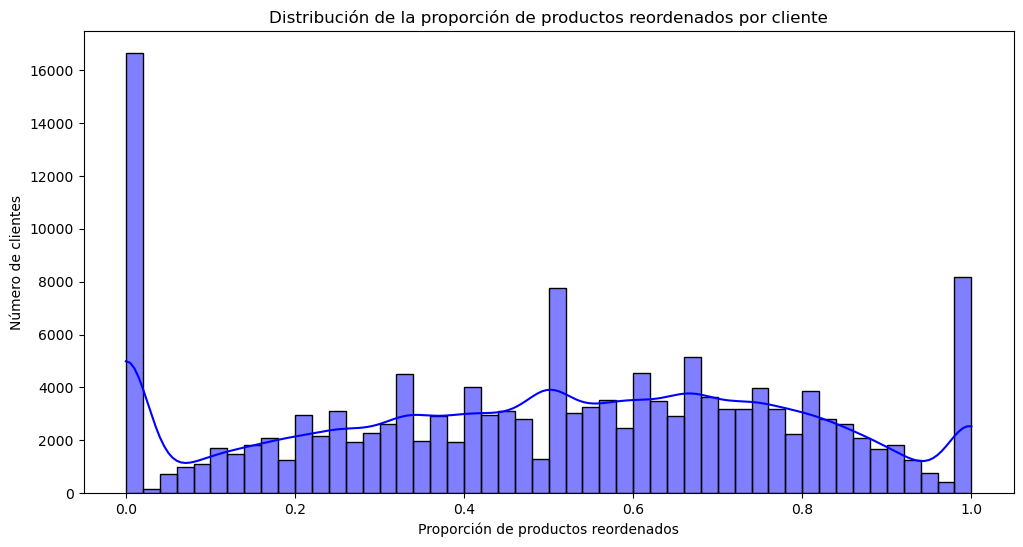

In [56]:
# Función para calcular la proporción de productos pedidos que se vuelven a pedir para cada cliente
def proporcion_reorden_por_cliente():
    query = 'SELECT f."user_id", SUM(f."reordered") / COUNT(f."product_id") AS "PROPORCION_REORDEN" FROM FACT_ORDERS_PRODUCTS f GROUP BY f."user_id" ORDER BY "PROPORCION_REORDEN" DESC;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Histograma de la proporción de productos reordenados por cliente
    plt.figure(figsize=(12,6))
    sns.histplot(df['PROPORCION_REORDEN'], bins=50, kde=True, color="blue")
    plt.xlabel("Proporción de productos reordenados")
    plt.ylabel("Número de clientes")
    plt.title("Distribución de la proporción de productos reordenados por cliente")
    plt.show()

proporcion_reorden_por_cliente()


Un número considerable de clientes tiene una proporción de reorden cercana a 0, lo que significa que compran una vez y no vuelven a comprar los mismos productos. Esto puede deberse a compradores ocasionales, pruebas de productos o falta de incentivos para la recompra. Además, también hay un grupo importante de clientes que recompran los mismos productos en cada pedido.Para aumentar la rentabilidad del negocio, es crucial mejorar la retención de clientes ocasionales y potenciar la recompra con estrategias de fidelización y suscripciones. 

/var/folders/ln/mfkv6_4j2zq5t91clsbxgnx00000gn/T/ipykernel_6844/3980641461.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df['PRODUCT_NAME'], y=df['PRIMERO_CARRITO'], palette="Blues_r")


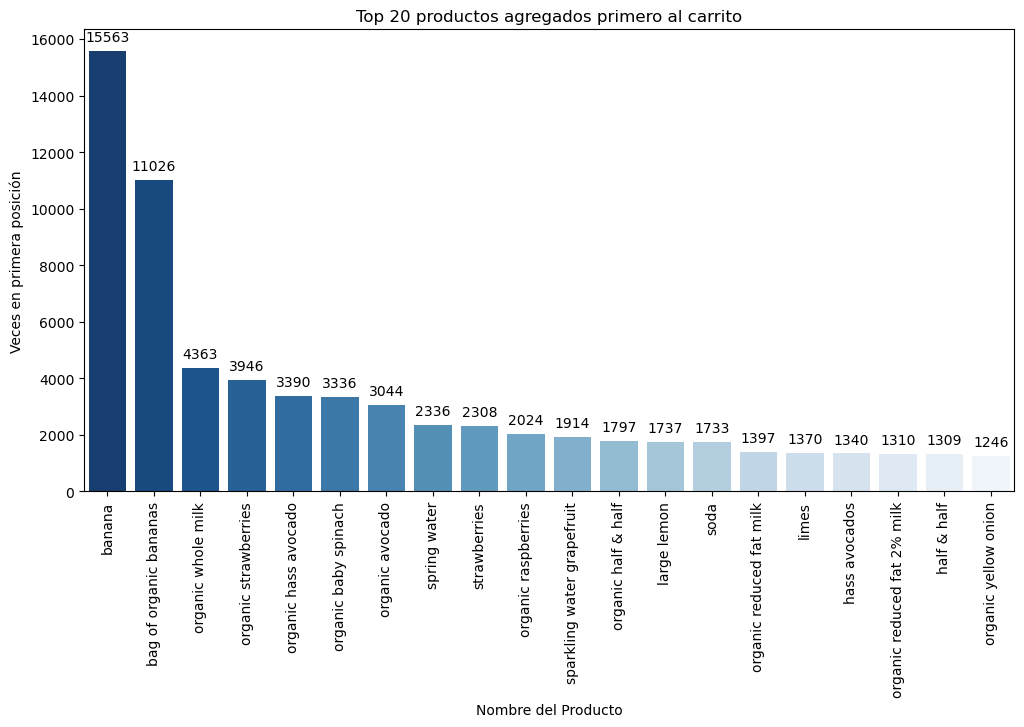

In [3]:
# Función para obtener el top 20 artículos que la gente pone primero en el carrito
def top_20_primero_en_carrito():
    query = 'SELECT p."product_name", COUNT(*) AS "PRIMERO_CARRITO" FROM FACT_ORDERS_PRODUCTS f JOIN DIM_PRODUCTS p ON f."product_id" = p."product_id" WHERE f."add_to_cart_order" = 1 GROUP BY p."product_name" ORDER BY "PRIMERO_CARRITO" DESC LIMIT 20;'
    df = obtener_datos(query)
    df.columns = df.columns.str.upper()
    
    # Gráfico de barras de los 20 productos más comunes en primera posición
    plt.figure(figsize=(12,6))
    ax = sns.barplot(x=df['PRODUCT_NAME'], y=df['PRIMERO_CARRITO'], palette="Blues_r")
    plt.xlabel("Nombre del Producto")
    plt.ylabel("Veces en primera posición")
    plt.title("Top 20 productos agregados primero al carrito")
    plt.xticks(rotation=90)
    
    # Agregar etiquetas sobre cada barra con la frecuencia exacta
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.show()

top_20_primero_en_carrito()

Se confirma que los clientes priorizan productos básicos, frescos y orgánicos al iniciar sus compras. De hecho, la banana es el producto agregado primero al carrito con 15,563 veces, seguida por la bolsa de bananas orgánicas con 11,026 veces, indicando una tendencia hacia hábitos de compra saludables. Así pues, para mejorar la conversión y retención, se recomienda optimizar el stock, ofrecer promociones estratégicas y aprovechar la ubicación de estos productos en la tienda online. También se pueden implementar estrategias de cross-selling para aumentar el valor del ticket promedio y mejorar la experiencia de compra.